In [1]:
import numpy as np 
import scipy.stats as sp
from uhod import camels as CAMELS

In [2]:
import corner as DFM
import matplotlib.pyplot as plt

In [3]:
ahf = CAMELS.AHF(33)

In [4]:
ahf['logMvir'] = np.log10(ahf['Mvir'])
ahf['logMstar'] = np.log10(ahf['M_star'])

/opt/anaconda3/envs/uhod/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [5]:
ahf['ID', 'hostHalo', 'numSubStruct', 'logMvir', 'logMstar'][:10]

ID,hostHalo,numSubStruct,logMvir,logMstar
int64,int64,int64,float64,float64
6945605822536072607,0,5,13.764790138873847,11.75291463509087
7652295877950794799,0,9,13.7460789122575,11.786449013861688
6069738113270115990,0,3,13.382436717803058,11.339318250494506
6031538411873867951,0,6,13.3318684532532,11.43788526831774
5995033307264235308,0,1,13.309530097855435,11.209214657728474
5974930252732468425,0,1,13.284532245365378,11.470203144526925
6018438307129578440,0,1,13.181935008739112,11.423712694379626
6721138173791394176,0,2,13.162271592157525,11.390109870205453
6511244706410756724,7652295877950794799,0,12.973744667954344,11.435395193007155


In [6]:
is_halo = (ahf['hostHalo'] == 0) # halo not a subhalo 
halos = ahf[is_halo]

In [7]:
has_galaxy = (halos['M_star'] > 0)

# halos with central galaxies
ncen_h = np.zeros(len(halos))
ncen_h[has_galaxy] = 1.

has_massive_galaxy = (halos['M_star'] > 1e9)
ncen_logmcut_h = np.zeros(len(halos))
ncen_logmcut_h[has_massive_galaxy] = 1.

nsat_h = halos['numSubStruct']

(0.0, 3.0)

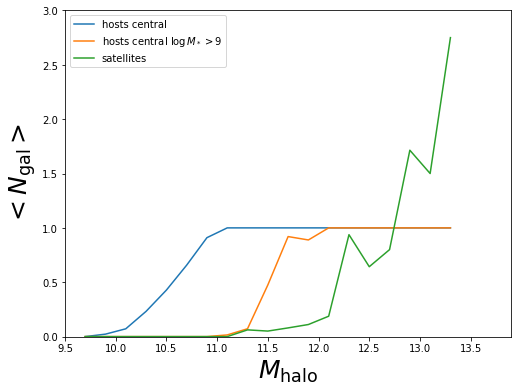

In [8]:
ncen_mh, mh_edges, _ = sp.binned_statistic(halos['logMvir'], ncen_h, bins=30, range=(8., 14))
ncen_mh_logmcut, _, _ = sp.binned_statistic(halos['logMvir'], ncen_logmcut_h, bins=30, range=(8., 14))
nsat_mh, mh_edges, _ = sp.binned_statistic(halos['logMvir'], nsat_h, bins=30, range=(8., 14))

fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.plot(0.5*(mh_edges[:-1] + mh_edges[1:]), ncen_mh, label='hosts central')
sub.plot(0.5*(mh_edges[:-1] + mh_edges[1:]), ncen_mh_logmcut, label=r'hosts central $\log M_* > 9$')
sub.plot(0.5*(mh_edges[:-1] + mh_edges[1:]), nsat_mh, label='satellites')

sub.legend(loc='upper left', fontsize=10)
sub.set_xlabel(r'$M_{\rm halo}$', fontsize=25)
sub.set_ylabel(r'$<N_{\rm gal}>$', fontsize=25)
sub.set_ylim(0., 3)

# subhalos

In [9]:
subhalos = ahf[~is_halo]

In [10]:
host_indices = []
for host_id in subhalos['hostHalo']: 
    assert np.sum(ahf['ID'] == host_id) == 1
    host_indices.append(np.arange(len(ahf))[ahf['ID'] == host_id][0])
host_indices = np.array(host_indices)

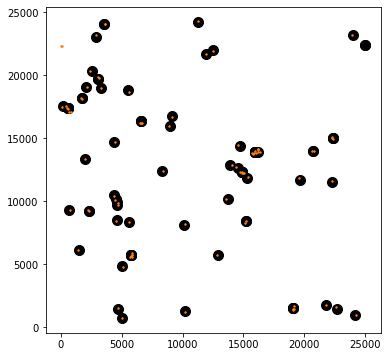

In [11]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(ahf['Xc'][host_indices], ahf['Yc'][host_indices], c='k', s=100)
sub.scatter(subhalos['Xc'], subhalos['Yc'], c='C1', s=2)

# halo properties

In [17]:
halo_props = np.vstack([halos[prop].data for prop in ['logMvir', 'Vmax', 'sigV', 'lambda', 'cNFW']]).T

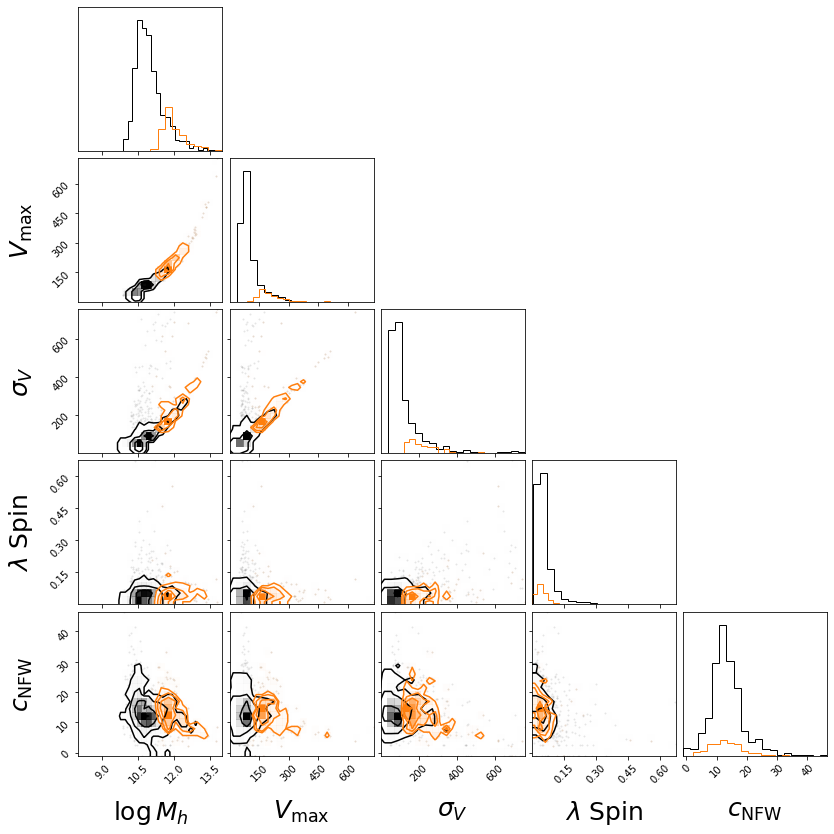

In [19]:
fig = DFM.corner(halo_props[ncen_h.astype(bool)])
_ = DFM.corner(halo_props[ncen_logmcut_h.astype(bool)], color='C1', fig=fig,
                range=[(8., 14.), (0., 600), (0, 600), (0., 0.5), (0., 45)], 
                labels=[r'$\log M_h$', r'$V_{\rm max}$', r'$\sigma_V$', r'$\lambda$ Spin', r'$c_{\rm NFW}$'], 
                label_kwargs={'fontsize': 25})